# Platform for Live Crypto Trading with ML

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import utils.load_crypto_assets as lc

# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [75]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [84]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="1h",starting_date = '1 Mar 2017')

In [85]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [86]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

starting time: 01 Mar 2017 00:00:00
ending time: 04 Jun 2022 15:00:00
All caught up..!
size of dataset: (41934, 8)


In [87]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4313.62,4261.32,4308.83,47.181009,171.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502946000,1502946000,4308.83,4328.69,4291.37,4315.32,23.234916,102.0,2017-08-17 05:01:00,2017-08-17 05:15:00
1502949600,1502949600,4330.29,4345.45,4309.37,4324.35,7.229691,36.0,2017-08-17 06:01:00,2017-08-17 06:15:00
1502953200,1502953200,4316.62,4349.99,4287.41,4349.99,4.443249,25.0,2017-08-17 07:01:00,2017-08-17 07:15:00
1502956800,1502956800,4333.32,4377.85,4333.32,4360.69,0.972807,28.0,2017-08-17 08:01:00,2017-08-17 08:15:00
...,...,...,...,...,...,...,...,...,...
1654340400,1654340400,29729.90,29742.09,29594.91,29681.69,897.049960,24020.0,2022-06-04 11:01:00,2022-06-04 11:15:00
1654344000,1654344000,29681.68,29703.64,29516.01,29538.00,1134.573450,30457.0,2022-06-04 12:01:00,2022-06-04 12:15:00
1654347600,1654347600,29538.00,29654.52,29522.99,29596.11,960.734620,24470.0,2022-06-04 13:01:00,2022-06-04 13:15:00


In [138]:
candles = ldata_df[["Date","LowBitcoin","HighBitcoin","OpenBitcoin","CloseBitcoin","VolumeBitcoin"]].copy()
candles.set_index("Date",inplace = True)
candles.rename(columns = {"LowBitcoin":"Low","HighBitcoin":"High","OpenBitcoin":"Open","CloseBitcoin":"Close","VolumeBitcoin":"Volume"},inplace=True)

#  "Wick Candles"

---

# Data Exploration


In [139]:
print('Available Dates:', candles.iloc[0].name, '-', candles.iloc[-1].name)
print(len(candles.index), 'candles')

Available Dates: 2017-08-17 04:01:00 - 2022-06-04 15:01:00
41934 candles


## Charts

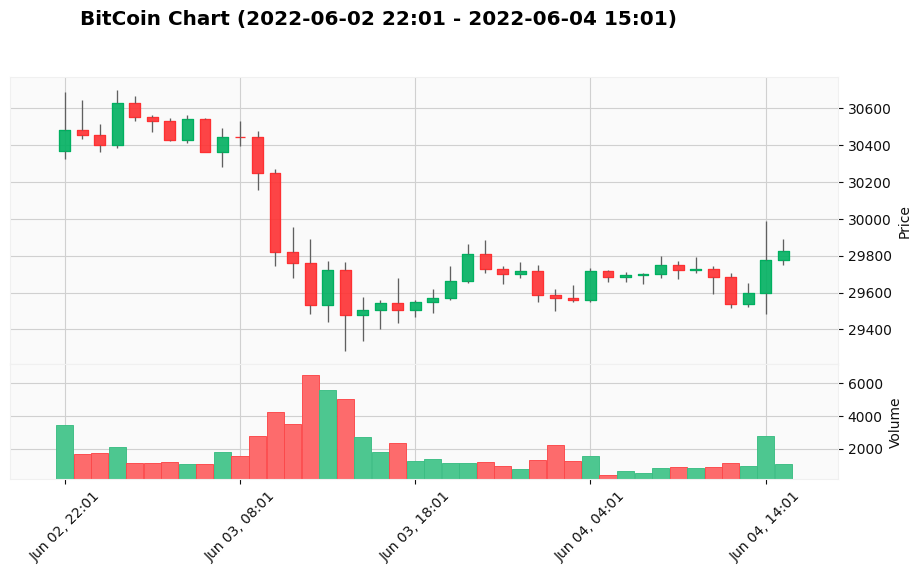

In [140]:
title = 'BitCoin Chart (' + str(candles.iloc[-42].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-42:], 
    type='candle', 
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

# Technical Analysis

## Moving Averages

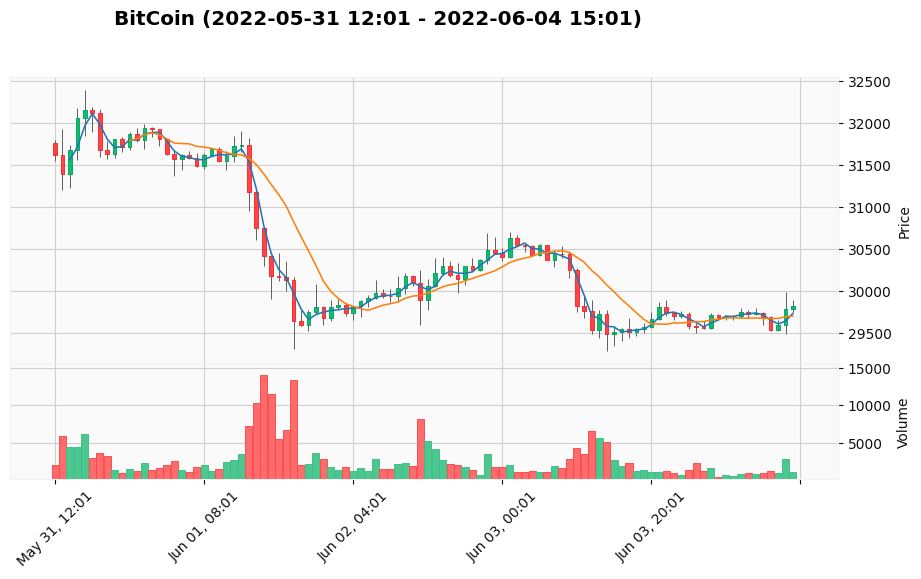

In [141]:
title = 'BitCoin (' + str(candles.iloc[-100].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-100:], 
    mav=(3, 11), 
    type='candle', 
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

##  Bollinger Bands

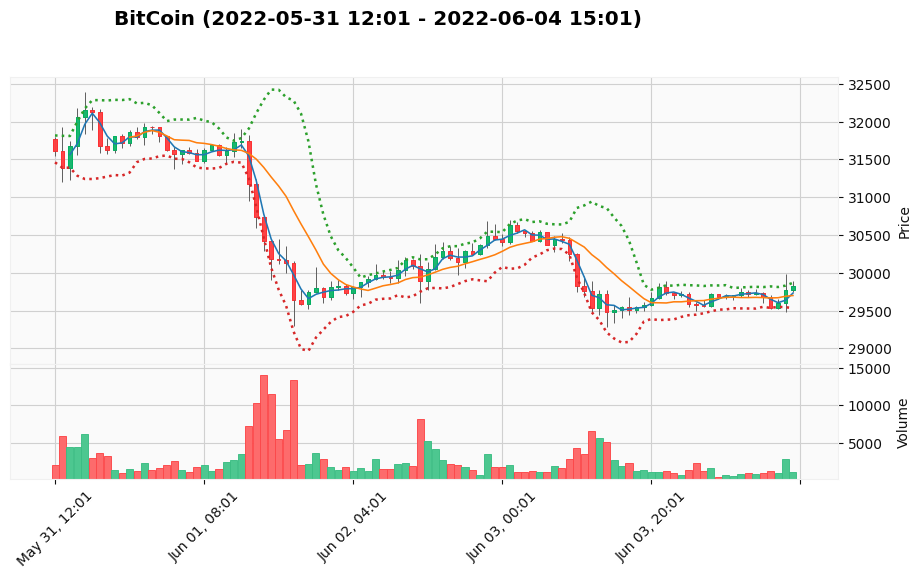

In [142]:
mean = candles['Close']
mean = mean.rolling(window=10).mean()
std_dev = candles['Close']
std_dev = std_dev.rolling(window=10).std()
candles['UpperBB'] = mean + (2 * std_dev)
candles['LowerBB'] = mean - (2 * std_dev)
bollinger_bands = candles[['UpperBB', 'LowerBB']]

bollinger_bands_plot = mpf.make_addplot(bollinger_bands[-100:], linestyle='dotted')
mpf.plot(
    candles.iloc[-100:], 
    type='candle',
    mav=(3, 11),
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    addplot=bollinger_bands_plot, 
    title=title
)

## Price to Volume Ratio

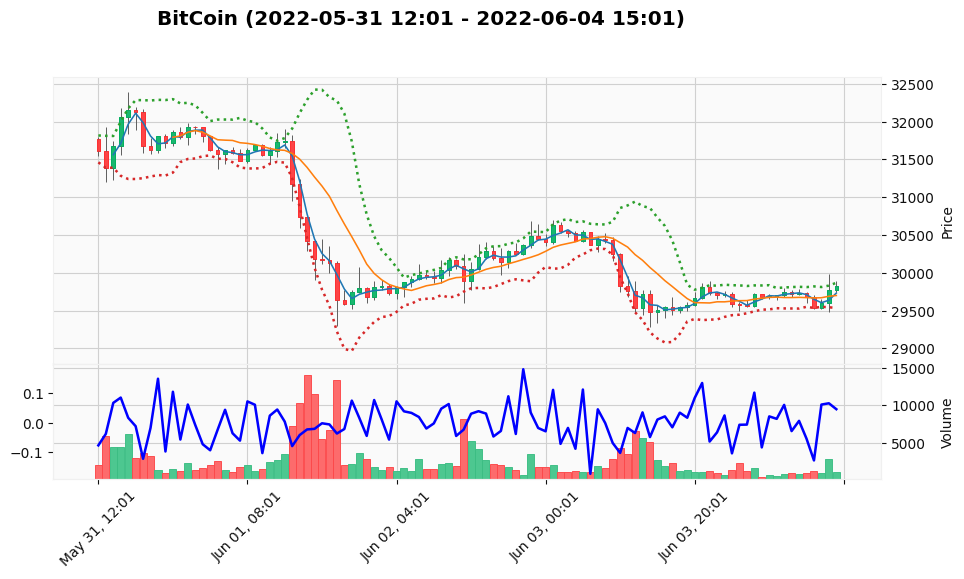

In [143]:
price_over_volume = (candles['Close'] - candles['Open']) / candles['Volume']

candles['price_over_vol'] = price_over_volume

price_over_volume_plot = mpf.make_addplot(price_over_volume[-100:], panel=1, color='blue')
mpf.plot(
    candles.iloc[-100:],
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[bollinger_bands_plot, price_over_volume_plot],
    title=title
)

## Volume Acceleration

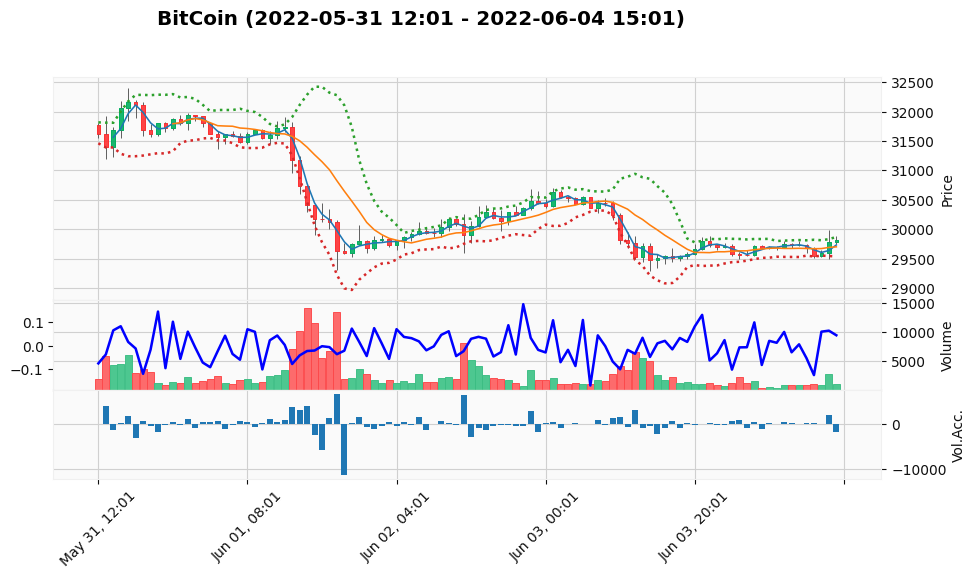

In [144]:
volume_diff = candles['Volume'] - candles['Volume'].shift(1)
volume_diff_plot = mpf.make_addplot(volume_diff[-100:], panel=2, type='bar', ylabel='Vol.Acc.')
candles['vol_diff'] = volume_diff

mpf.plot(
    candles.iloc[-100:],  
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[
        bollinger_bands_plot, 
        price_over_volume_plot, 
        volume_diff_plot
    ], 
    title=title
)

# Generate timeseries
## Normalize data

In [145]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
candles_norm = scaler.fit_transform(candles)

print(candles.iloc[0])
print('  ------')
print(candles_norm[0])

Low               4261.320000
High              4313.620000
Open              4261.480000
Close             4308.830000
Volume              47.181009
UpperBB                   NaN
LowerBB                   NaN
price_over_vol       1.003582
vol_diff                  NaN
Name: 2017-08-17 04:01:00, dtype: float64
  ------
[0.21320336 0.21238716 0.21268696 0.21268967 0.20059905        nan
        nan 0.27258592        nan]


In [149]:
len(candles)

41934

## Remove NaNs
due to Bolliger Bands and moving averages

In [106]:
candles_norm = candles_norm[10:]
TEST=False
if not TEST:
    RECENT_DATA = 40000
    candles_norm = candles_norm[-RECENT_DATA:]
    print(len(candles_norm))


40000


## Generate dataset based on timeseries

In [70]:
x_candles = []
x_time = []
y = []

step_back = 48

for i in range(len(candles_norm) - step_back):
    example_candles = []
    example_time = []

    if TEST:
        for o in range(0, step_back):
            example_candles.append(candles_norm[i + o])
            t = candles.iloc[10 + i + o].name
            example_time.append([t.hour / 24, t.weekday() / 7])
    else:
        for o in range(0, step_back):
            example_candles.append(candles_norm[i + o])
            t = candles.iloc[10 + i + o].name
            example_time.append([t.minute / 60., t.hour/24])      

    x_candles.append(example_candles)
    x_time.append(example_time)
    y.append(candles_norm[i+step_back][3])

KeyboardInterrupt: ignored

In [74]:
candles.iloc[10 + i + o].name.minute/60

0.7666666666666667

In [ ]:
plt.plot(candles['Close'])
plt.title('BitCoin close', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('real values')
plt.show()

plt.plot(y)
plt.title('BitCoin close ', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('normalized values')
plt.show()

In [ ]:
np.shape(x_candles)

### Create training and validation datasets

In [ ]:
split_point = int(len(x_candles) * 0.9)

x_train_candles = np.asarray(x_candles[:split_point], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point], dtype=np.float32)
y_train = np.asarray(y[:split_point], dtype=np.float32)

x_test_candles = np.asarray(x_candles[split_point:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point:], dtype=np.float32)
y_test = np.asarray(y[split_point:], dtype=np.float32)

In [ ]:
print(x_train_candles.shape)
print(x_train_time.shape)
print(y_train.shape)
print('from', candles.iloc[0].name, 'to', candles.iloc[split_point + step_back].name)

print('   --------')

print(x_test_candles.shape)
print(x_test_time.shape)
print(y_test.shape)
print('from', candles.iloc[split_point + step_back + 1].name, 'to', candles.iloc[-step_back].name)

## Implement predictive model
---

#### Use the"Swish" activation function

In [40]:
def swish(x):
    return keras.backend.sigmoid(x) * x

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['Candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['Candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['Candles[0][0]']                
                                                                                              

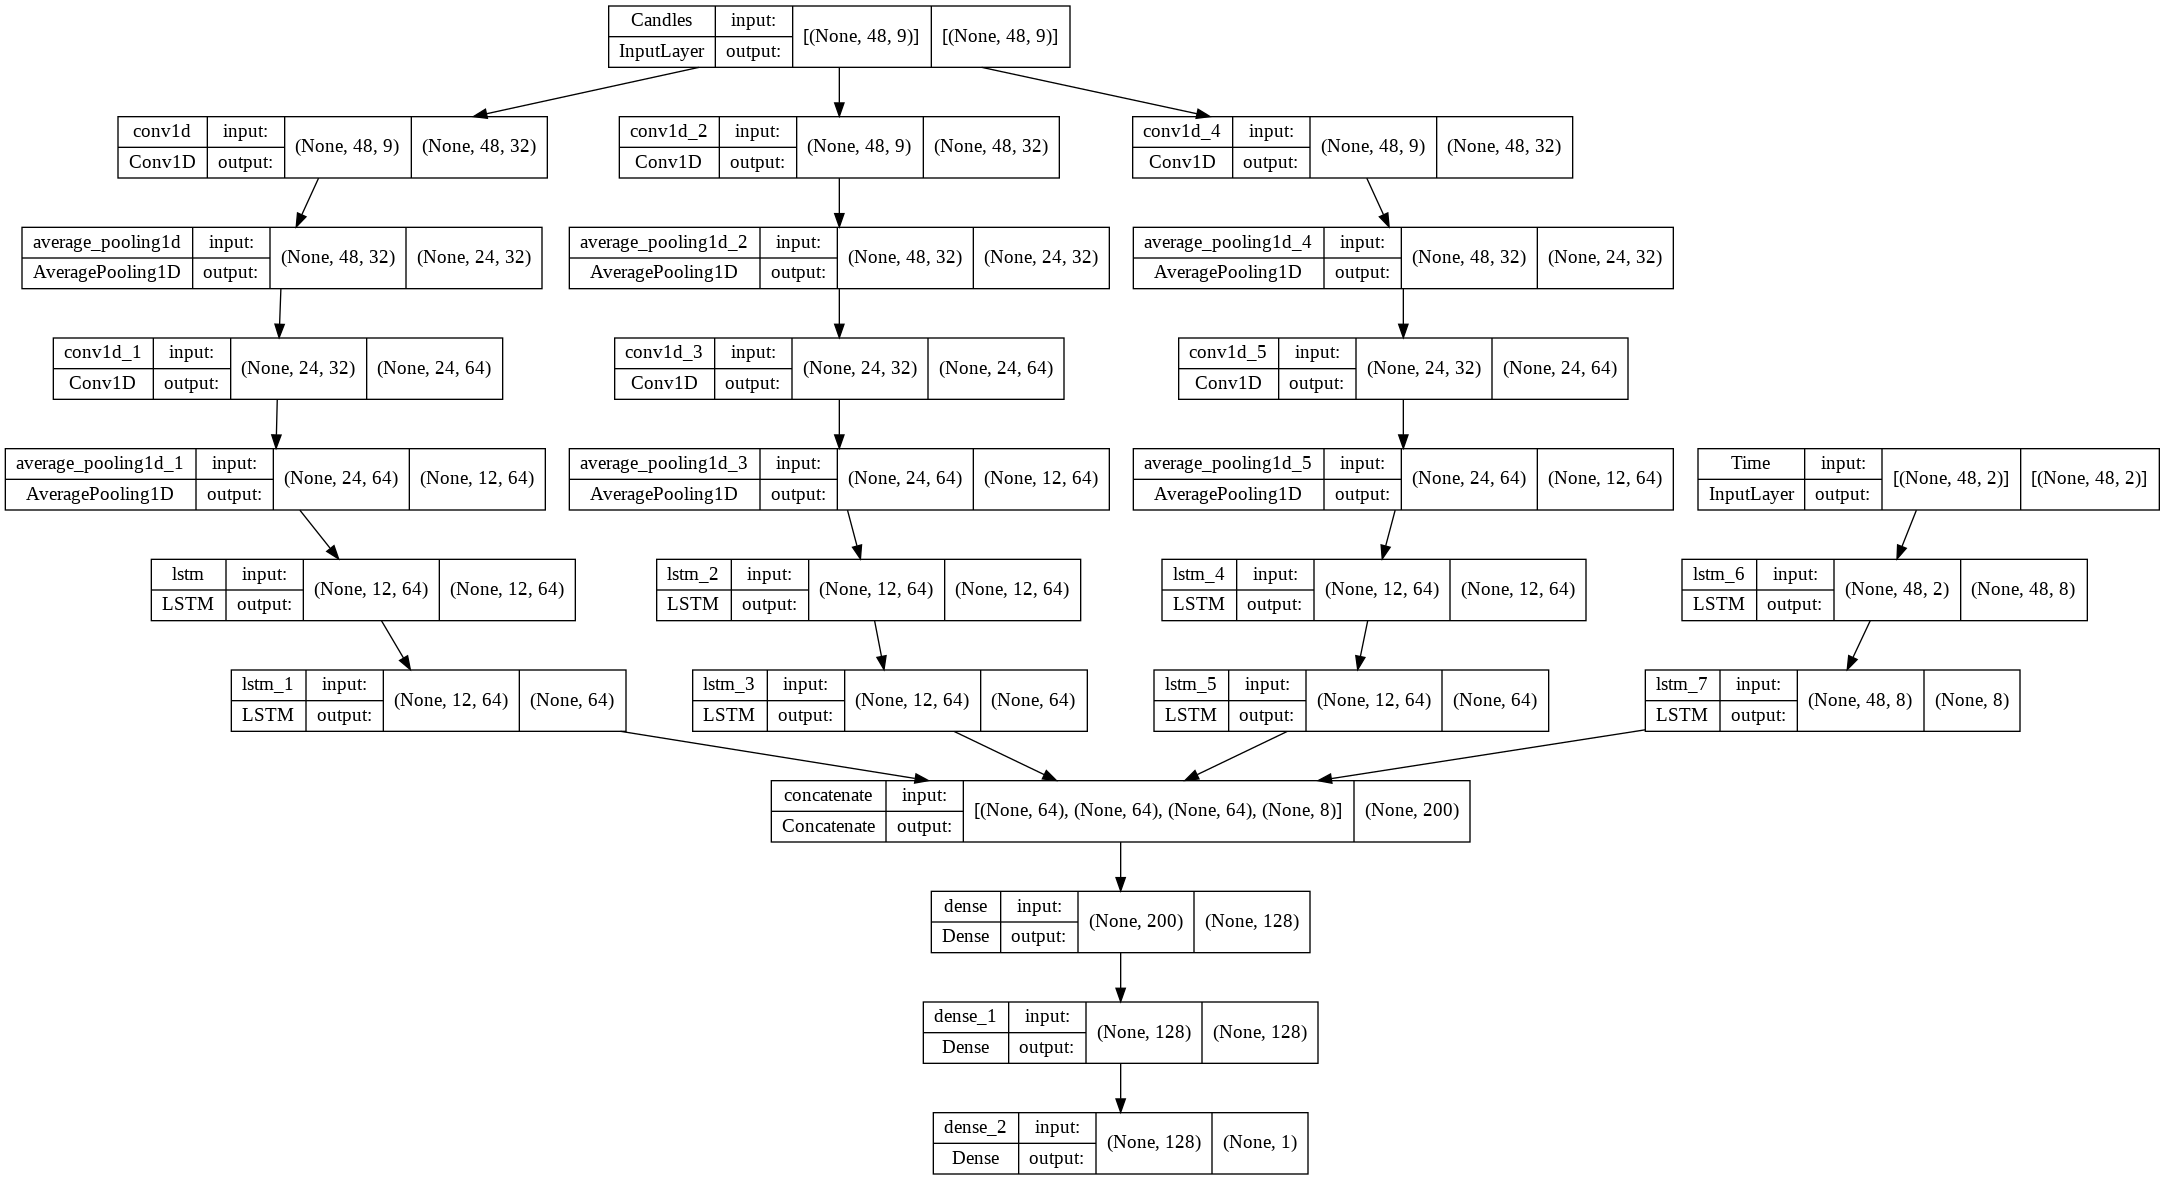

In [41]:
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D()(conv_1)
    
    conv_2 = keras.layers.Conv1D(
        filters=64,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D()(conv_2)
    
    lstm_1 = keras.layers.LSTM(units=64, return_sequences=True)(average_2)
    lstm_2 = keras.layers.LSTM(units=64)(lstm_1)
    
    return lstm_2


input_candles = keras.Input(shape=(x_train_candles.shape[1], x_train_candles.shape[2]), name='Candles')
input_time = keras.Input(shape=(x_train_time.shape[1], x_train_time.shape[2]), name='Time')

conv_1 = get_conv_lstm_block(input_candles, kernel_size_1=3, kernel_size_2=3)
conv_2 = get_conv_lstm_block(input_candles, kernel_size_1=7, kernel_size_2=7)
conv_3 = get_conv_lstm_block(input_candles, kernel_size_1=13, kernel_size_2=13)

lstm_time_1 = keras.layers.LSTM(units=8, return_sequences=True)(input_time)
lstm_time_2 = keras.layers.LSTM(units=8)(lstm_time_1)

conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, lstm_time_2])

dense_1 = keras.layers.Dense(units=128, activation=keras.activations.swish)(conc)
dense_2 = keras.layers.Dense(units=128, activation=keras.activations.swish)(dense_1)

output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_2)

model = keras.Model(inputs=[input_candles, input_time], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_absolute_error)

model.summary()
keras.utils.plot_model(model, "conv_lstm_net.png", show_shapes=True)

In [42]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time],
    y_train,
    epochs=20,
    batch_size=4096,
    validation_data=(
        [x_test_candles, x_test_time],
        y_test
    ),
    callbacks=model_checkpoint_callback
)

model.load_weights('weights/weights')

Epoch 1/20
14/14 [==============================] - 27s 340ms/step - loss: nan - val_loss: nan
Epoch 2/20
14/14 [==============================] - 1s 84ms/step - loss: nan - val_loss: nan
Epoch 3/20
14/14 [==============================] - 1s 84ms/step - loss: nan - val_loss: nan
Epoch 4/20
14/14 [==============================] - 1s 85ms/step - loss: nan - val_loss: nan
Epoch 5/20
14/14 [==============================] - 1s 84ms/step - loss: nan - val_loss: nan
Epoch 6/20
14/14 [==============================] - 1s 85ms/step - loss: nan - val_loss: nan
Epoch 7/20
14/14 [==============================] - 1s 85ms/step - loss: nan - val_loss: nan
Epoch 8/20
14/14 [==============================] - 1s 85ms/step - loss: nan - val_loss: nan
Epoch 9/20
14/14 [==============================] - 1s 85ms/step - loss: nan - val_loss: nan
Epoch 10/20
14/14 [==============================] - 1s 85ms/step - loss: nan - val_loss: nan
Epoch 11/20
14/14 [==============================] - 1s 85ms/step -

NotFoundError: ignored

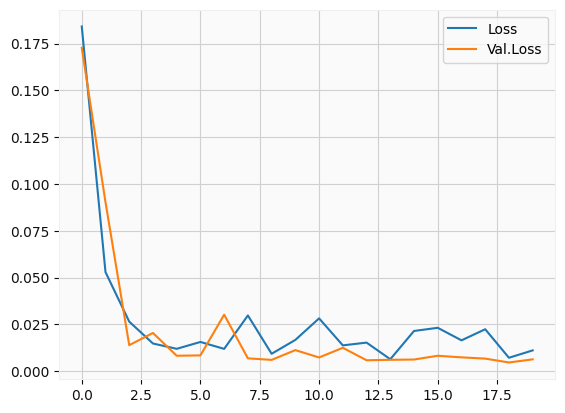

In [ ]:

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Utilizzo e validazione del modello predittivo

In [ ]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

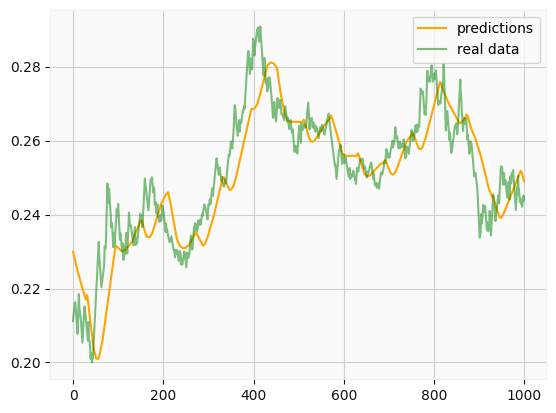

In [ ]:
plt.plot(preds[-1000:], color='orange', label='predictions')
plt.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [ ]:
def log_return(series, periods=1):
    log_ret = np.log(series).diff(periods=periods)
    if periods < 0:
        log_ret*= -1.
    return log_ret

In [ ]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


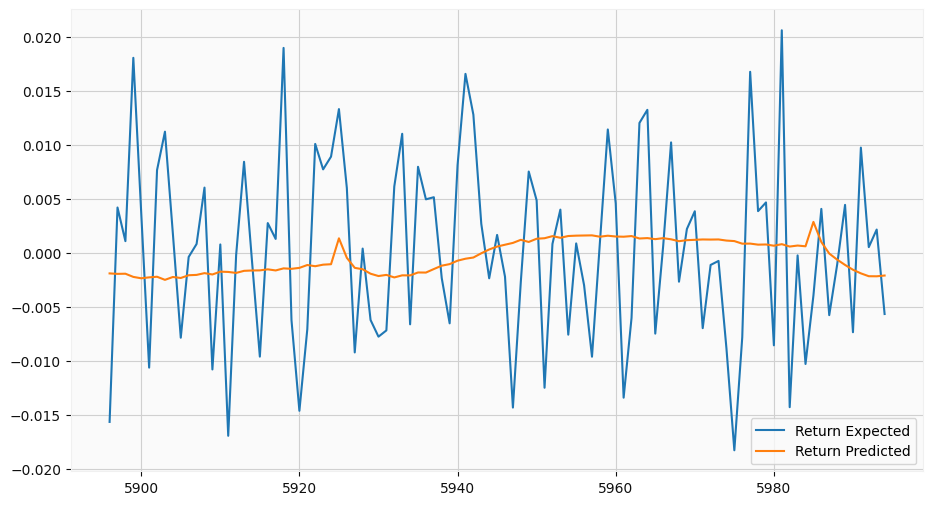

In [ ]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [ ]:
def denorm(value):
    example = [0.5 for x in range(9)]
    example[3] = value
    return scaler.inverse_transform([example])[0][3]

In [ ]:
def backtesting(fee=0.025):
    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    for i in range(split_point, len(x_candles)):
        prediction = preds[i - split_point][0]
        predicted_close = denorm(prediction)
        previous_close = denorm(candles_norm[i][3])
        real_next_close = denorm(candles_norm[i+1][3])

        if (previous_close + (previous_close * fee)) < predicted_close:  # buy
            profit = real_next_close - previous_close
            if profit > 0:
                profit = profit - (profit * fee)
                buys_cnt_win += 1
                old_profit_negative = False
            else:
                profit = profit + (profit * fee)
                buys_cnt_losses += 1
                if old_profit_negative:
                    old_profits += profit
                else:
                    old_profits = profit
                if old_profits < drawback:
                    drawback = old_profits
                old_profit_negative = True
            wallet += profit
            total_wallet_history.append(wallet)
            single_wallet_history.append(profit)
            buys_cnt += 1
        else:
            old_profit_negative = False
            old_profits = 0

    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('No-op   ', (len(x_candles) - split_point) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      0 ( 0 ok 0 ko )
No-op    3996
Wallet   0
Drawback 0


Total earned 68262.60824999999


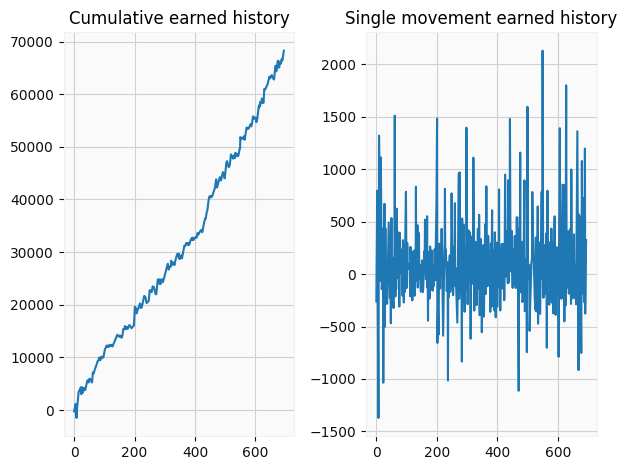

In [ ]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## addestramento su più epoche

In [ ]:
preds_old = preds
y_test_old = y_test

In [ ]:
many_epochs = 200
print(f'training on {many_epochs} epochs...')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time], 
    y_train, 
    epochs=many_epochs,
    initial_epoch=21, 
    batch_size=4096,
    validation_data=([x_test_candles, x_test_time], y_test),
    callbacks=model_checkpoint_callback,
    verbose=1
)

training on 200 epochs...
Epoch 22/200
14/14 [==============================] - 1s 87ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 23/200
14/14 [==============================] - 1s 86ms/step - loss: 0.0094 - val_loss: 0.0147
Epoch 24/200
14/14 [==============================] - 1s 87ms/step - loss: 0.0093 - val_loss: 0.0066
Epoch 25/200
14/14 [==============================] - 1s 86ms/step - loss: 0.0092 - val_loss: 0.0154
Epoch 26/200
14/14 [==============================] - 1s 85ms/step - loss: 0.0091 - val_loss: 0.0069
Epoch 27/200
14/14 [==============================] - 1s 81ms/step - loss: 0.0093 - val_loss: 0.0143
Epoch 28/200
14/14 [==============================] - 1s 86ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 29/200
14/14 [==============================] - 1s 86ms/step - loss: 0.0090 - val_loss: 0.0149
Epoch 30/200
14/14 [==============================] - 1s 86ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 31/200
14/14 [==============================] - 1s 81ms/ste

In [ ]:
model.load_weights('weights/weights')

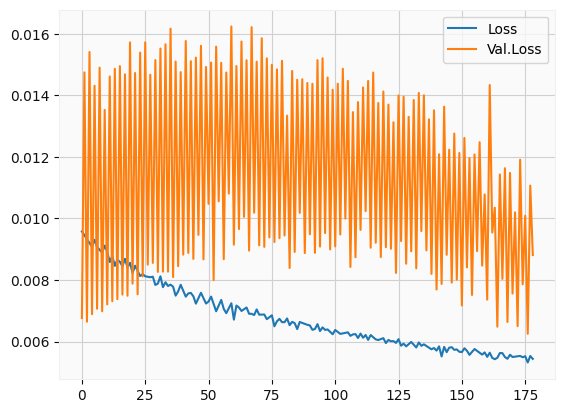

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

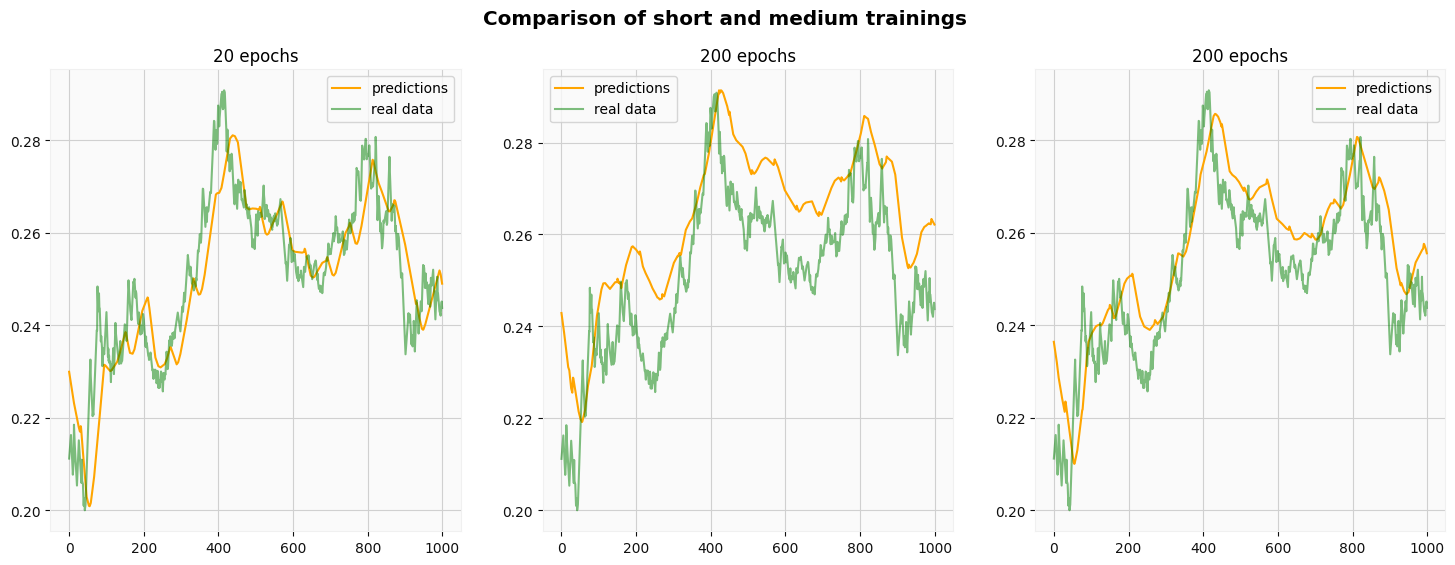

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Comparison of short and medium trainings')

ax1.set_title('20 epochs')
ax1.plot(preds_old[-1000:], color='orange', label='predictions')
ax1.plot(y_test_old[-1000:], color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('200 epochs')
ax2.plot(preds[-1000:], color='orange', label='predictions')
ax2.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('200 epochs')
ax3.plot((preds[-1000:]+preds_old[-1000:])/2, color='orange', label='predictions')
ax3.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax3.legend()


plt.show()

In [ ]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


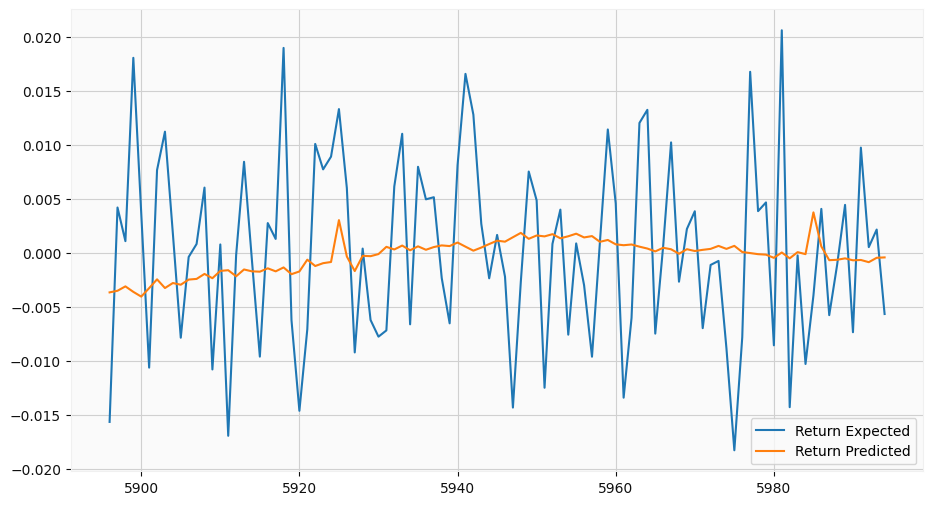

In [ ]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [ ]:
total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      1485 ( 832 ok 653 ko )
No-op    2845
Wallet   82080.603
Drawback -2639.5287500000013


Total earned 82080.603


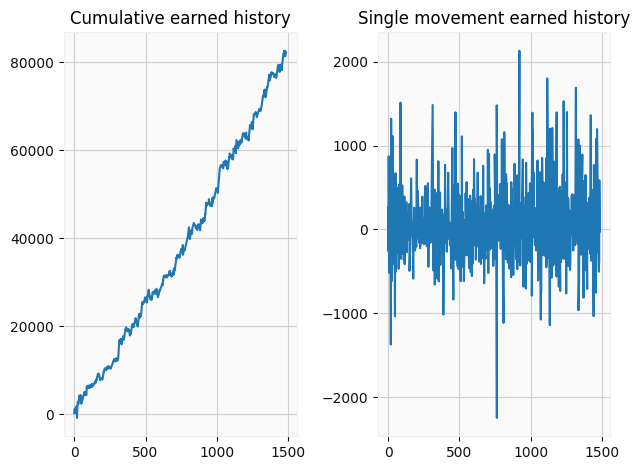

In [ ]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()